# Creating the tidal forcing

In [1]:
from roms_tools import Grid

We first create our grid object. In this example, the grid contains Iceland and has a horizontal resolution of 1000km/500 = 2km with 100 vertical layers.

In [2]:
grid = Grid(
    nx=500,
    ny=500,
    size_x=1000,
    size_y=1000,
    center_lon=-20,
    center_lat=65,
    rot=0,
    N=100,
    topography_source={
        "name": "SRTM15",
        "path": "/global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc",
    },
)

Given our grid, our goal is now to create the necessary tidal forcing fields to run a ROMS simulation.

Tidal forcing is based on the TPXO atlas and uses three key files:

* Grid file: TPXO bathymetry and land mask
* H file: Tidal elevation
* U file: Tidal transports

`ROMS-Tools` applies a Self-Attraction and Loading (SAL) correction by subtracting it from the equilibrium tide to compute the tidal potential. This correction, which accounts for Earth deformation and ocean mass redistribution, is sourced internally from TPXO9v2a, as it is not included in the regularly updated TPXO datasets.

The three TPXO files are available on Perlmutter at the following locations:

In [3]:
tpxo_path = "/global/cfs/projectdirs/m4746/Datasets/TPXO/TPXO10.v2/"
tpxo_dict = {
    "grid": tpxo_path + "grid_tpxo10v2.nc",
    "h": tpxo_path + "h_tpxo10.v2.nc",
    "u": tpxo_path + "u_tpxo10.v2.nc",
}

You can also download your own version. For more details, please refer to [this page](https://roms-tools.readthedocs.io/en/latest/datasets.html).

We now create our tidal forcing for a model reference date of January 1st, 2000.

In [4]:
from roms_tools import TidalForcing

In [5]:
from datetime import datetime

In [6]:
model_reference_date = datetime(2000, 1, 1)

In [7]:
%%time

tidal_forcing = TidalForcing(
    grid=grid,
    source={"name": "TPXO", "path": tpxo_dict},
    ntides=15,  # Number of constituents to consider <= 15. Default is 10.
    model_reference_date=model_reference_date,  # Model reference date. Default is January 1, 2000.
)

INFO - Applying 2D horizontal fill to the source data before regridding.
INFO - Applying 2D horizontal fill to the source data before regridding.
INFO - Applying 2D horizontal fill to the source data before regridding.
INFO - Applying 2D horizontal fill to the source data before regridding.


CPU times: user 2min 51s, sys: 2.84 s, total: 2min 54s
Wall time: 27.9 s


To see the values of the tidal forcing variables we can examine the `xarray.Dataset` object returned by the `.ds` property.

In [8]:
tidal_forcing.ds

<xarray.Dataset> Size: 121MB
Dimensions:  (ntides: 15, eta_rho: 502, xi_rho: 502, xi_u: 501, eta_v: 501)
Coordinates:
  * ntides   (ntides) |S3 45B b'm2' b's2' b'n2' b'k2' ... b'ms4' b'2n2' b's1'
    omega    (ntides) float64 120B 0.0001405 0.0001454 ... 0.0001352 7.272e-05
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v
Data variables:
    ssh_Re   (ntides, eta_rho, xi_rho) float32 15MB 0.4586 0.4597 ... -0.0001645
    ssh_Im   (ntides, eta_rho, xi_rho) float32 15MB -0.5377 ... -0.002517
    pot_Re   (ntides, eta_rho, xi_rho) float32 15MB 0.04873 ... 0.0005769
    pot_Im   (ntides, eta_rho, xi_rho) float32 15MB 0.0006086 ... -0.0004161
    u_Re     (ntides, eta_rho, xi_u) float32 15MB -0.03715 ... -2.756e-05
    u_Im     (ntides, eta_rho, xi_u) float32 15MB 0.02533 0.02547 ... 3.903e-05
    v_Re     (ntides, eta_v, xi_rho) float32 15MB 0.01661 0.01673 ... -1.493e-05
    v_Im     (ntides, eta_v, xi_rho) float32 15MB -0.02923 ... -0.0001484
Attributes:
    title:                 ROMS tidal forcing created by ROMS-Tools
    roms_tools_version:    2.6.3.dev44+g780e06f.d20250623
    source:                TPXO
    model_reference_date:  2000-01-01 00:00:00

## Plotting the tidal forcing fields

We can also plot any of the tidal forcing fields via the `.plot` method.

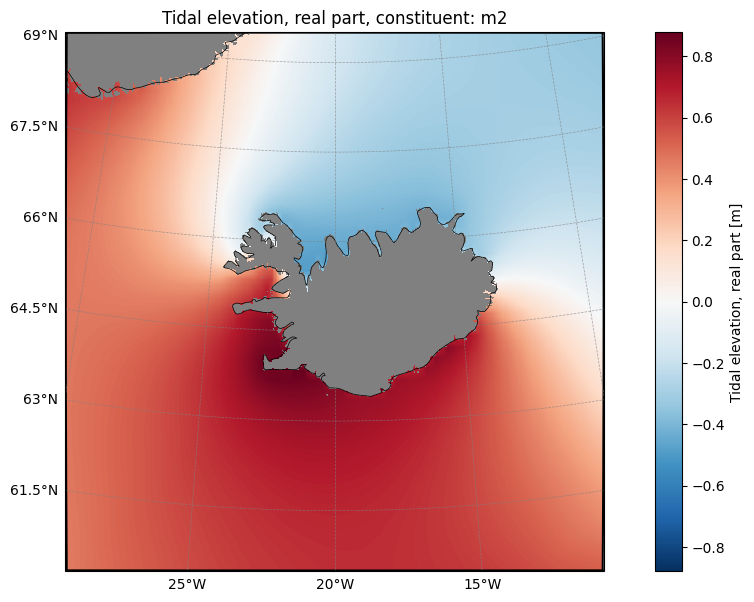

In [9]:
tidal_forcing.plot("ssh_Re", ntides=0)  # first tidal constituent

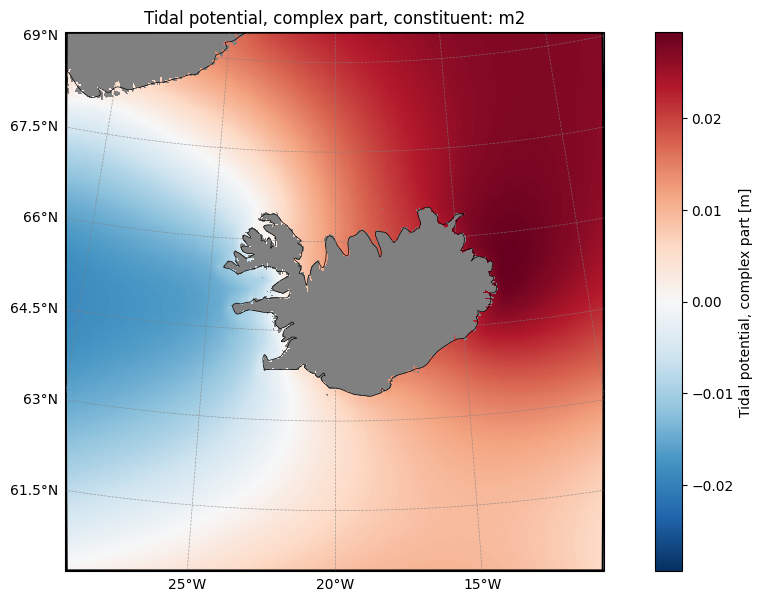

In [10]:
tidal_forcing.plot("pot_Im", ntides=0)  # first tidal constituent

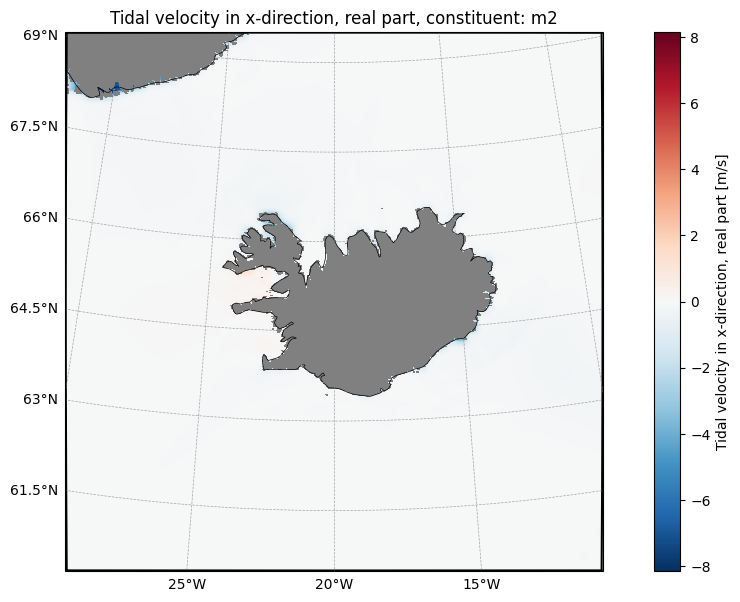

In [11]:
tidal_forcing.plot("u_Re", ntides=0)  # first tidal constituent

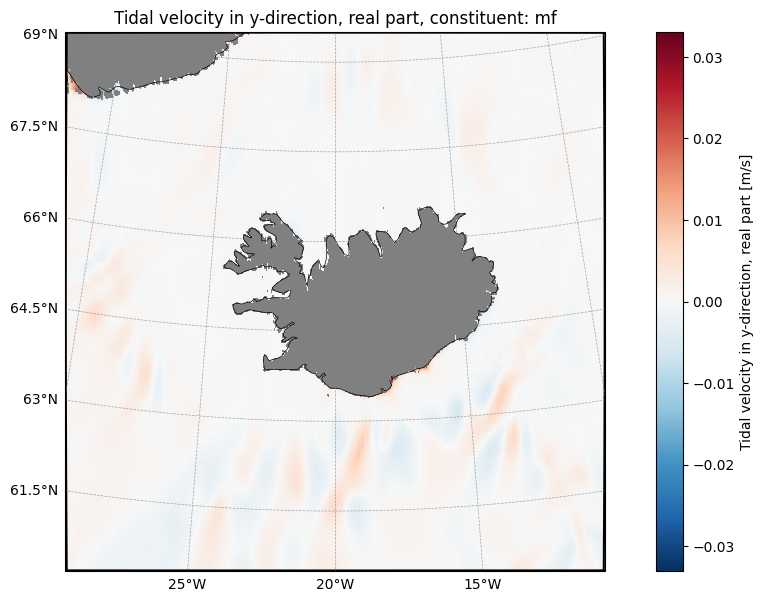

In [12]:
tidal_forcing.plot("v_Re", ntides=9)  # tenth tidal constituent

## Saving as NetCDF or YAML file

Finally, we can save our tidal forcing as a netCDF file via the `.save` method.

In [13]:
filepath = "/pscratch/sd/n/nloose/forcing/my_tidal_forcing.nc"

In [14]:
%time tidal_forcing.save(filepath)

INFO - Writing the following NetCDF files:
/pscratch/sd/n/nloose/forcing/my_tidal_forcing.nc


CPU times: user 31 ms, sys: 140 ms, total: 171 ms
Wall time: 182 ms


[PosixPath('/pscratch/sd/n/nloose/forcing/my_tidal_forcing.nc')]

We can also export the parameters of our `TidalForcing` object to a YAML file.

In [15]:
yaml_filepath = "/pscratch/sd/n/nloose/forcing/my_tidal_forcing.yaml"

In [16]:
tidal_forcing.to_yaml(yaml_filepath)

In [17]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 2.6.3.dev44+g780e06f.d20250623
---
Grid:
  nx: 500
  ny: 500
  size_x: 1000
  size_y: 1000
  center_lon: -20
  center_lat: 65
  rot: 0
  N: 100
  theta_s: 5.0
  theta_b: 2.0
  hc: 300.0
  topography_source:
    name: SRTM15
    path: /global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc
  hmin: 5.0
TidalForcing:
  source:
    name: TPXO
    path:
      grid: /global/cfs/projectdirs/m4746/Datasets/TPXO/TPXO10.v2/grid_tpxo10v2.nc
      h: /global/cfs/projectdirs/m4746/Datasets/TPXO/TPXO10.v2/h_tpxo10.v2.nc
      u: /global/cfs/projectdirs/m4746/Datasets/TPXO/TPXO10.v2/u_tpxo10.v2.nc
  ntides: 15
  model_reference_date: '2000-01-01T00:00:00'
  bypass_validation: false



## Creating tidal forcing from an existing YAML file

In [18]:
%time the_same_tidal_forcing = TidalForcing.from_yaml(yaml_filepath)

INFO - Applying 2D horizontal fill to the source data before regridding.
INFO - Applying 2D horizontal fill to the source data before regridding.
INFO - Applying 2D horizontal fill to the source data before regridding.
INFO - Applying 2D horizontal fill to the source data before regridding.


CPU times: user 2min 36s, sys: 2.34 s, total: 2min 39s
Wall time: 27.3 s


In [19]:
the_same_tidal_forcing.ds

<xarray.Dataset> Size: 121MB
Dimensions:  (ntides: 15, eta_rho: 502, xi_rho: 502, xi_u: 501, eta_v: 501)
Coordinates:
  * ntides   (ntides) |S3 45B b'm2' b's2' b'n2' b'k2' ... b'ms4' b'2n2' b's1'
    omega    (ntides) float64 120B 0.0001405 0.0001454 ... 0.0001352 7.272e-05
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v
Data variables:
    ssh_Re   (ntides, eta_rho, xi_rho) float32 15MB 0.4586 0.4597 ... -0.0001645
    ssh_Im   (ntides, eta_rho, xi_rho) float32 15MB -0.5377 ... -0.002517
    pot_Re   (ntides, eta_rho, xi_rho) float32 15MB 0.04873 ... 0.0005769
    pot_Im   (ntides, eta_rho, xi_rho) float32 15MB 0.0006086 ... -0.0004161
    u_Re     (ntides, eta_rho, xi_u) float32 15MB -0.03715 ... -2.756e-05
    u_Im     (ntides, eta_rho, xi_u) float32 15MB 0.02533 0.02547 ... 3.903e-05
    v_Re     (ntides, eta_v, xi_rho) float32 15MB 0.01661 0.01673 ... -1.493e-05
    v_Im     (ntides, eta_v, xi_rho) float32 15MB -0.02923 ... -0.0001484
Attributes:
    title:                 ROMS tidal forcing created by ROMS-Tools
    roms_tools_version:    2.6.3.dev44+g780e06f.d20250623
    source:                TPXO
    model_reference_date:  2000-01-01 00:00:00